# Variations of two-step maximisation algorithm

In this notebook we make various changes to the two-step maximisation algorithm in order to get more robust clustering behaviour. At the end we arrive to the Expectation-Maximisation (EM) algorithm. 
To be less abstract we provide an explicit two-step algorithm for Gaussian components.
This can be easily modified to handle more general cluster components. 

In [1]:
import numpy as np
import pandas as pd
import numpy.random as rnd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

from pandas import Series
from pandas import DataFrame
from typing import List,Tuple

from pandas import Categorical
from pandas.api.types import CategoricalDtype

from tqdm import tnrange#, tqdm_notebook
from plotnine import *

from scipy.stats import norm
from scipy.stats import multivariate_normal

# Local imports
from common import *
from convenience import *

## I. Necessary subroutines and initial setup

Before we can start with the two-step maximisation algorithm, we introduce some visualisation functions and set initial parameters for the algorithm.

### Visualisation for cluster shape 

Simple function to visualise confidence envelopes for Gaussian distributions:

In [2]:
def geom_ellipse(mean: np.array, cov: np.array, data: np.array=None, q: float=0.95, **kwargs):
    """
    Draws confidence envelope for a multivariate normal distribution
    
    The ellipse can be specified by mean and covariance. Use stats_ellipse(level=q) to draw
    the empirical confidence envelopes for the data.
    """

    # Radius that covers q-fraction of white Gaussian noise  
    r = np.sqrt(stats.chi2.ppf(q=q, df=2))
    
    # Eigen-directions of a covariance matrix
    try:
        L, W = np.linalg.eigh(cov)
    except:
        return geom_path(aes(x = 'x', y = 'y'), data = DataFrame(columns=['x', 'y']))
    
    # Properly scaled eigen-directions
    W[0, :] = W[0, :] * r * np.sqrt(L[0]) 
    W[1, :] = W[1, :] * r * np.sqrt(L[1]) 
   
    theta = np.linspace(0, 2 * np.pi, 100)
   
    return geom_path(aes(x = 'x', y = 'y'), data = DataFrame()
                     .assign(x = mean[0] + np.sin(theta) * W[0, 0] + np.cos(theta) * W[1, 0])
                     .assign(y = mean[1] + np.sin(theta) * W[0, 1] + np.cos(theta) * W[1, 1]), **kwargs)

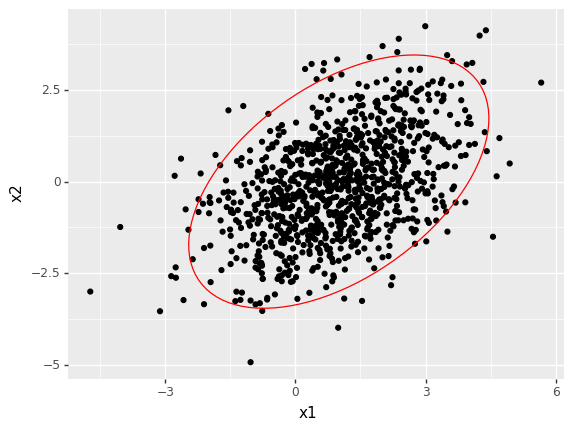

<ggplot: (-9223372036545054183)>

In [3]:
mu = np.array([1,0])
Sigma = np.array([[2, 1], [1, 2]])

p = ggplot(DataFrame(multivariate_normal(mean=mu, cov=Sigma).rvs(1000), columns = ['x1', 'x2']))
p = p + geom_point(aes(x = 'x1', y = 'x2'))
p + geom_ellipse(mean=mu, cov=Sigma, q=0.95, color="red")

### Example data to run the two-step maximisation algorithm

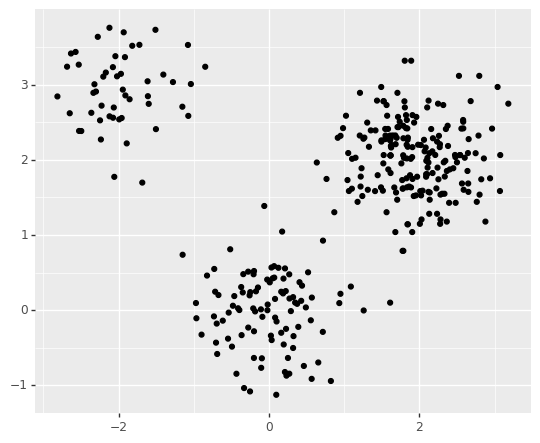

<ggplot: (309721755)>

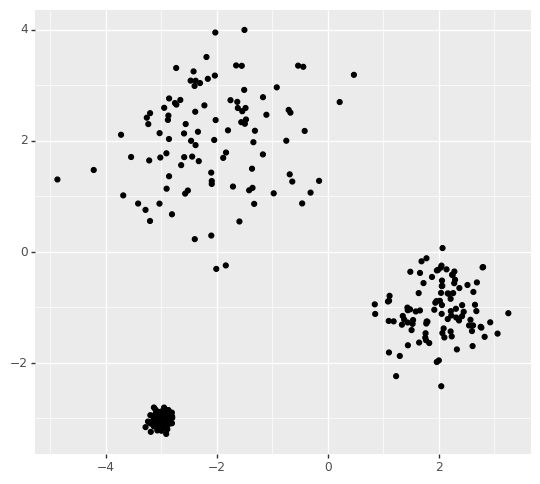

<ggplot: (-9223372036542913585)>

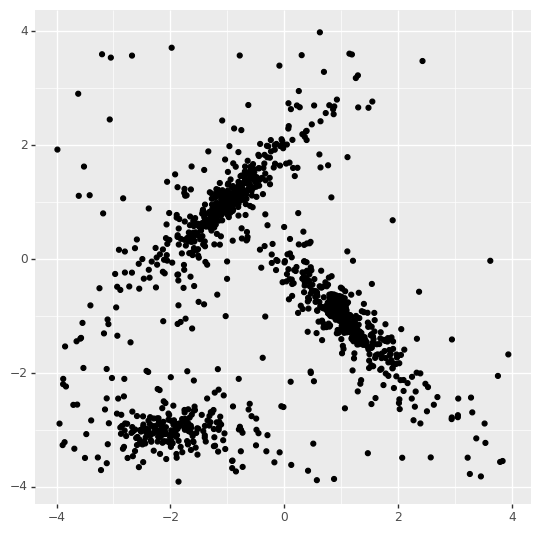

<ggplot: (-9223372036542906126)>

In [4]:
for i in range(1, 4):
    df = pd.read_csv('data/gmm-challenges/challenge-{:d}.csv'.format(i))
    p = ggplot(df)
    p = p + geom_point(aes(x = 'x', y = 'y'))
    p = p + coord_fixed()
    p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
    display(p)

### Initial parameter values for all our experiments

There are several ways to store parameters in the two-step maximisation algorithm. We choose the most pandas-like representation that uses indices for selecting parameters for individual clusters.

$\mu$ $\Sigma$ 
 
 
 cluster 
 x 
 y 
 
 
 
 
 0 
 -2.525507 
 -1.133098 
 
 
 1 
 2.501579 
 2.605186 
 
 
 2 
 -0.154752 
 -0.493544 
 
 
 
 
 
 cluster 
 x 
 y 
 
 
 
 
 0 
 1.0 
 0.0 
 
 
 0 
 0.0 
 1.0 
 
 
 1 
 1.0 
 0.0 
 
 
 1 
 0.0 
 1.0 
 
 
 2 
 1.0 
 0.0 
 
 
 2 
 0.0 
 1.0

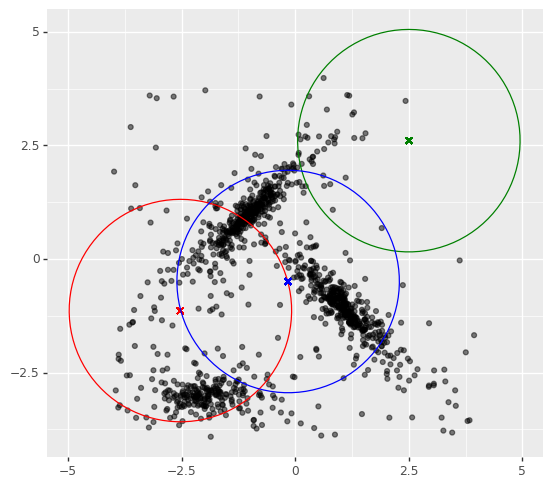

<ggplot: (312274254)>

In [5]:
Mu = (DataFrame(np.array([
                [-2.5255070, -1.1330980],
                [ 2.5015790,  2.6051860],
                [-0.1547520, -0.4935437]]),columns=['x', 'y'])
      .assign(cluster = range(3))
      .set_index('cluster'))

Sigma = DataFrame(np.identity(2), columns = ['x', 'y'], index = ['x', 'y'])
Sigma = pd.concat([Sigma.assign(cluster = j) for j in range(3)]).set_index('cluster')

mdisplay([Mu.reset_index(), Sigma.reset_index()], [r'$\mu$', r'$\Sigma$'])

p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y'), alpha = 0.5)
p = p + coord_fixed()
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
for i, color in enumerate(['red', 'green', 'blue']):
    p = p + geom_point(x = Mu.loc[i,'x'], y = Mu.loc[i, 'y'], color = color, shape = 'x', size = 2)
    p = p + geom_ellipse(mean=Mu.loc[i], cov=Sigma.loc[i], color=color)
display(p)

## II. General form of the two-step minimisation algorithm for Gaussian components

The two-step algorithm specified below logs all parameter values during its work. For that we use data frames with multi-indices. This can lead to [subtle errors when we want to assign data frames](https://stackoverflow.com/questions/28431519/pandas-multiindex-assignment-from-another-dataframe) due to index mismatches. Thus, we cast the data frames to `numpy` arrays.  

In [6]:
def HardGMMClustering2D(data: DataFrame, Mu:List[np.array], Sigma:List[np.array], maxit:int = 100):
    """Computes hard clustering and stores all intermediate values"""
    
    if len(Mu) != len(Sigma.index.unique()):
       Exception("Incorrectly specified initial paramaters")
       
    # Dimensions    
    k = len(Mu)
    n = data.shape[0]
    maxit = maxit + 1
    
    # Make sure that we do not alter inputs
    Mu = Mu.copy()
    Sigma = Sigma.copy()
    
    # Lets also store the log likelyhood of the model
    LLM = np.full([2 * maxit], np.nan)

    # Lets store all labellings and parameter values throughout the search
    Z = DataFrame(np.full([maxit, n], np.nan))  
    
    MU = (DataFrame(np.full([k * maxit, 2], np.nan), columns = ['x', 'y'])
          .assign(cluster = list(range(k)) * maxit)
          .assign(t = sum([[i] *  k for i in range(maxit)], []))
          .set_index(['t', 'cluster']))
    
    SIGMA = (DataFrame(np.full([maxit * 2 *  k, 2], np.nan), columns = ['x', 'y'])
             .assign(cluster = sum([[j, j] for j in range(k)],[]) * maxit)
             .assign(t = sum([[i] *  2 * k for i in range(maxit)], []))
             .set_index(['t', 'cluster']))   
    
    # Store parameters. Downcast to array to force assignment.
    MU.loc[0] = Mu.values
    SIGMA.loc[0] = Sigma.values
    
    for t in range(1, maxit):
        
        # Step M1: Find cluster probabilities and assign the label to most probable cluster
        lp = np.full([n, k], np.nan)
        
        for j in range(k):
            lp[:, j] = multivariate_normal.logpdf(data, mean = Mu.loc[j], cov = Sigma.loc[j]) 
            
        # Note that we should choose the most probable cluster!
        Z.loc[t] = lp.argmax(axis = 1)

        # Now we can compute the estimate of log p[data|z, Mu, Sigma]
        LLM[2 * t - 2] = np.amax(lp, axis=1).sum()
        

        # Obvious stop condition: Stop if the previous labelling was the same as the current labelling
        if all(Z.loc[t - 1] == Z.loc[t]):
            maxit = t  
            break    
        

        # Step M2: Recalibrate parameters for different clusters
        ll = np.full([k], np.nan)
        for j in range(k):
            
            # Select cluster points 
            X = data.loc[Z.loc[t] == j].values

            # Cluster center estimation
            Mu.loc[j] = np.mean(X, axis=0)
            
            # Cluster shape estimation
            # Center the data and compute the covariance
            X[:, 0] = X[:, 0] - Mu.loc[j, 'x']  
            X[:, 1] = X[:, 1] - Mu.loc[j, 'y'] 
            Sigma.loc[j] = 1/sum(Z.loc[t]==j) * np.dot(X.T, X)  
            
            # Update probability estimate for the cluster based on centered data 
            ll[j] = np.sum(multivariate_normal.logpdf(X, cov = Sigma.loc[j]))
            
        # Store loglikelihood    
        LLM[2 * t - 1] = sum(ll)

        # Store parameters. Downcast to array to force assignment.
        MU.loc[t] = Mu.values
        SIGMA.loc[t] = Sigma.values
     
    LLM = (DataFrame(LLM[:2 * maxit - 2], columns = ['loglikelihood'])
           .assign(t = sum([[i, i] for i in range(1, maxit)], []))
           .assign(step = sum([['M1', 'M2'] for i in range(1, maxit)], [])) 
           .assign(i = range(2 * maxit - 2))[['i', 't', 'step','loglikelihood']])
    return (Z[:maxit], MU.loc[:maxit-1], SIGMA.loc[:maxit-1], LLM)

### Example run and visualisations

In [7]:
df = pd.read_csv('data/gmm-challenges/challenge-1.csv', usecols = [1,2])
Z, MU, SIGMA, LLM = HardGMMClustering2D(df, Mu, Sigma)

Evolution of log-likelihood:

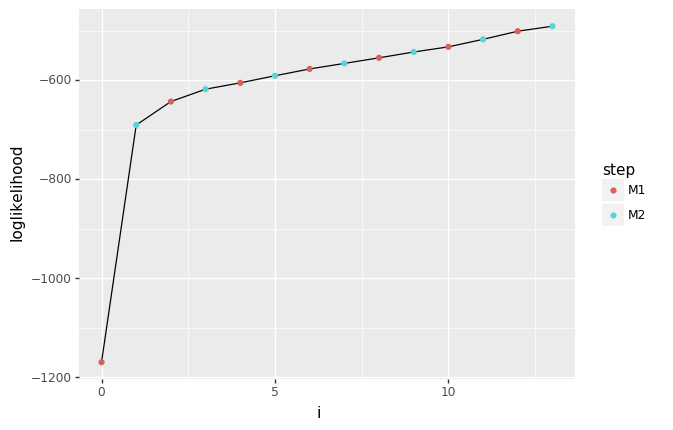

<ggplot: (311848456)>

In [8]:
p = ggplot(LLM) 
p = p + geom_line(aes(x='i', y = 'loglikelihood'))
p = p + geom_point(aes(x='i', y = 'loglikelihood', color ='step'))
display(p)

Evolution of cluster centers:

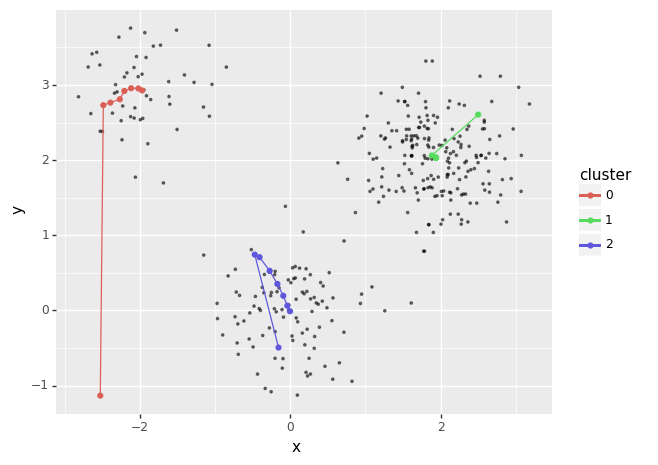

<ggplot: (-9223372036542242907)>

In [9]:
centers = MU.reset_index().assign(cluster=lambda df:df['cluster'].astype('category'))

p = ggplot(df) + geom_point(aes(x = 'x', y = 'y'), alpha=0.5, size=0.5) + coord_fixed()
p = p + geom_path(aes(x = 'x', y ='y', color = 'cluster'), data = centers)
p = p + geom_point(aes(x = 'x', y ='y', color = 'cluster'), data = centers)
p = p + scale_color_discrete()
display(p)

Evolution of cluster shapes:

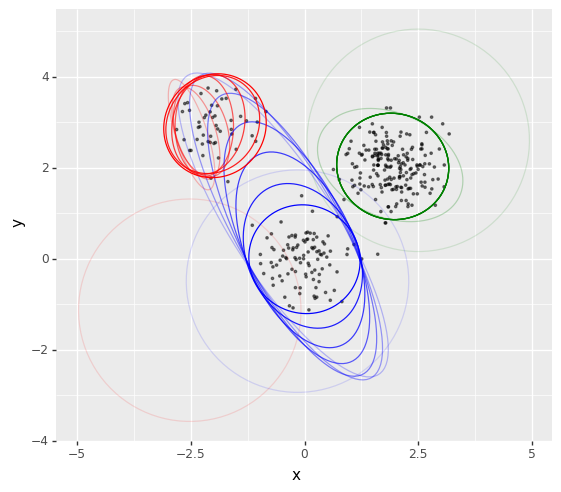

<ggplot: (311867603)>

In [10]:
p = ggplot(df) + geom_point(aes(x = 'x', y = 'y'), alpha=0.5, size=0.5) + coord_fixed()

tmax = SIGMA.index.get_level_values('t').max()
for t in SIGMA.index.get_level_values('t').unique():
    for k, color in enumerate(['red', 'green', 'blue']):
        p = p + geom_ellipse(mean = MU.loc[(t,k)], cov = SIGMA.loc[(t, k)], color = color, alpha = (1+t)/(tmax+1))
display(p)

## III. Two-step algorithm on duplicated data

As a first step towards the EM-algorithm, we show that the two-step algorithm gives the same result on duplicated data as on original data, provided that multiplicity of all data points is the same. 

In [11]:
mdf = pd.concat([df, df, df])
Z, MU, SIGMA, LLM = HardGMMClustering2D(mdf, Mu, Sigma)

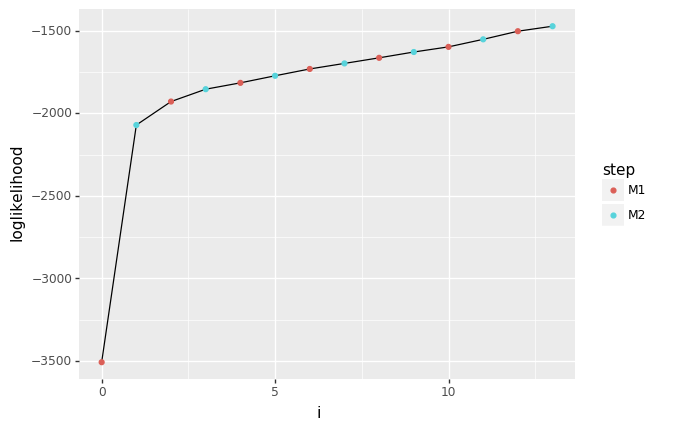

<ggplot: (-9223372036541930727)>

In [12]:
p = ggplot(LLM) 
p = p + geom_line(aes(x='i', y = 'loglikelihood'))
p = p + geom_point(aes(x='i', y = 'loglikelihood', color ='step'))
display(p)

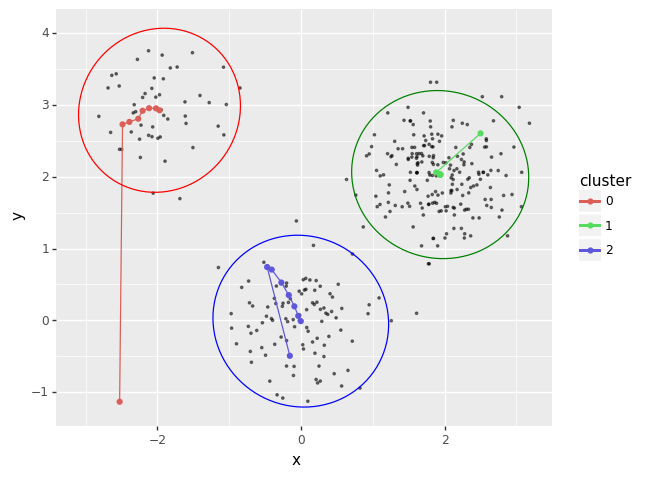

<ggplot: (312900079)>

In [13]:
centers = MU.reset_index().assign(cluster=lambda df:df['cluster'].astype('category'))

p = ggplot(df) + geom_point(aes(x = 'x', y = 'y'), alpha=0.5, size=0.5) + coord_fixed()
p = p + geom_path(aes(x = 'x', y ='y', color = 'cluster'), data = centers)
p = p + geom_point(aes(x = 'x', y ='y', color = 'cluster'), data = centers)

tmax = SIGMA.index.get_level_values('t').max()
for k, color in enumerate(['red', 'green', 'blue']):
    p = p + geom_ellipse(mean = MU.loc[(tmax,k)], cov = SIGMA.loc[(tmax, k)], color = color)

p = p + scale_color_discrete()

display(p)

# Homework

## 1.1 Stabilsation through local outlier removal (<font color='red'>1p</font>)

Hard clustering methods can become unstable due to outliers which corrupt the estimation of cluster parameters. One way to make clustering methods more robust is to throw out $5$-$10$\% of cluster points that have the lowest likelihood to be part of the cluster. 

Modify the hard clustering algorithm given above so that up to $\alpha$ fraction of points assigned to the cluster are removed before parameter estimation. Study whether the modified algorithm remains stable on challenge datasets stored in the directory [`data/gmm-challenges`](./data/gmm-challenges). For that use the same random initial state for both algorithms and see whether the modified algorithm converges to the same set of parameters.
A simple comparative graph which shows cluster centres and data ellipses for both methods is enough. You can use [`stat_ellipse`](https://plotnine.readthedocs.io/en/stable/generated/plotnine.stats.stat_ellipse.html) or `geom_ellipse` defined above.

## 1.2 Stabilisation through global outlier removal (<font color='red'>1p</font>)

Another way to make hard clustering more stable is to perform outlier removal globally. That is, for each data point $\boldsymbol{x}_i$ you compute the maximal likelihood

\begin{align*}
 \mathrm{pmax}[\boldsymbol{x}_i]=\max_j p[\boldsymbol{x}_i|\boldsymbol{\Theta}_j]
\end{align*}

and in each iteration remove $\alpha$ fraction of points with the lowest $\mathrm{pmax}[\boldsymbol{x}_i]$ scores. Modify the hard clustering algorithm to accommodate this tweak. Modify both outlier removal algorithms so that they would output also the log-likelihood of selected data $\log p[\boldsymbol{x}_{i_1},\ldots,\boldsymbol{x}_{i_\ell}|\boldsymbol{z},\boldsymbol{\Theta}]$ in each iteration. Plot corresponding log-likelihood graph.  Do the algorithms with local and global outlier removal methods have different behaviour? If so, which of them is more stable? 

**Clarification:** Study the behaviour of both modified algorithms on [`challenge-3.csv`](./data/gmm-challenges/challenge-3.csv) to which you have added $10\%$ outlier data uniformly sampled from the range $[-10,10]\times[-10,10]$.

## 1.3 Stabilisation through Poisson component* (<font color='red'>1p</font>)


Another way to make hard clustering more stable is to introduce a separate Poisson component for the noise. All points in the Poisson component get the same occurrence probability:
\begin{align*}
p[\boldsymbol{x}_i|\boldsymbol{x}_i\text{ is from the Poisson cluster}]=\alpha\,.
\end{align*}

As a result, again we have a global rule to remove cluster outliers, in particular those that are more likely to originate from the Poisson component than any other cluster. However, now we control the density of the Poisson component to remove outliers instead of always removing some fixed fraction of points.
Modify the hard clustering algorithm to accommodate this tweak. Additionally, output also the log-likelihood of selected data $\log p[\boldsymbol{x}_{i_1},\ldots,\boldsymbol{x}_{i_\ell}|\boldsymbol{z},\boldsymbol{\Theta}]$ in each iteration. Plot corresponding log-likelihood graph. Which of the three outlier removal algorithms seems to converge to the solution in the best way? Why? 

**Clarification:** Study the behaviour of all modified algorithms on [`challenge-3.csv`](./data/gmm-challenges/challenge-3.csv) to which you have added $10\%$ outlier data uniformly sampled from the range $[-10,10]\times[-10,10]$.

## 1.4 Comparison of various stabilisation algorithms* (<font color='red'>1p</font>)

Study the robustness of the modified hard clustering algorithms. For that use  [`challenge-3.csv`](./data/gmm-challenges/challenge-3.csv) and an initial configuration of parameters so that the methods converge to sensible outcomes. Add various levels of outlier data uniformly sampled from the range $[-10,10]\times[-10,10]$ to `challenge-3.csv` and study when the algorithms still converge to these sensible outcomes (observe cluster centres). Try different outlier levels $\beta=1,2,5,10,15,20,30,40,50\%$ and $\alpha = 1,5,10\%$. How much noise can be tolerated by the modified algorithms?    

## 1.5 Soft clustering with fractional counts (<font color='red'>2p</font>)   

Soft clustering does not assign points into particular clusters. Instead, it defines a probability $w_{ij}$ that a point $\boldsymbol{x}_i$ belongs to a $j$th cluster. 
As such, it is often intractable to get a closed-form update step for cluster parameters $\boldsymbol{\Theta}_j$.  Study how to convert the corresponding parameter estimation step in the hard clustering algorithm 

\begin{align*}
\boldsymbol{\Theta}_j=\mathrm{argmax}_{\boldsymbol{\Theta}_j}p[\boldsymbol{x}_{i_1},\ldots, \boldsymbol{x}_{i_{n_j}}|\boldsymbol{\Theta}_j]\,,
\end{align*}
where $\boldsymbol{x}_{i_1},\ldots, \boldsymbol{x}_{i_{n_j}}$ are all the datapoints belonging to the $j$th cluster,
into a parameter estimation step in the soft clustering algorithm if all clusters are generated by two-dimensional Gaussian distributions:

* Implement a tweak of the hard clustering algorithm that replicates all datapoints $10$ times and then assigns $c_{ij}$ instances of $\boldsymbol{x}_i$ to the $j$th cluster so that $c_{ij}$ are approximately proportional to the weights
 \begin{align*}
w_{ij}=\frac{\lambda_j p[\boldsymbol{x}_i|z_i=j,\boldsymbol{\Theta}_j]}{\lambda_1 p[\boldsymbol{x}_i|z_i=1,\boldsymbol{\Theta}_1]+\cdots+\lambda_k p[\boldsymbol{x}_i|z_i=k,\boldsymbol{\Theta}_k]}\,.
\end{align*}

 Modify the algorithm so that it still keeps track of the log-likelihood values of the entire dataset. To make the quantity independent from data multiplicity, divide the log-likelihood by $10$.

* Implement a tweak of the hard clustering algorithm that assigns datapoints according to the weights
 \begin{align*}
w_{ij}=\frac{\lambda_j p[\boldsymbol{x}_i|z_i=j,\boldsymbol{\Theta}_j]}{\lambda_1 p[\boldsymbol{x}_i|z_i=1,\boldsymbol{\Theta}_1]+\cdots+\lambda_k p[\boldsymbol{x}_i|z_i=k,\boldsymbol{\Theta}_k]}\,.
\end{align*}

 Modify the algorithm so that it still keeps track of the log-likelihood values of the entire dataset. Multiplicity is given by the weight directly in this formulation.

For both tweaks, study how the log-likelihood evolves during iterations. Make some conclusions.